# ResNet的论文复现
## 第一节

接下来是一段代码<br>

***
```python
int x = 666
print("hello world")
print("x = ", x)
```

***

公式<br>
$$E=mc^2$$

下划线
<u> underline <u><br>
 
*斜体*<br>
**粗体**<br>

删除线
~~end now.~~<br>


[链接名称](链接地址)

![liyili.jpg](打个码先attachment:liyili.jpg)
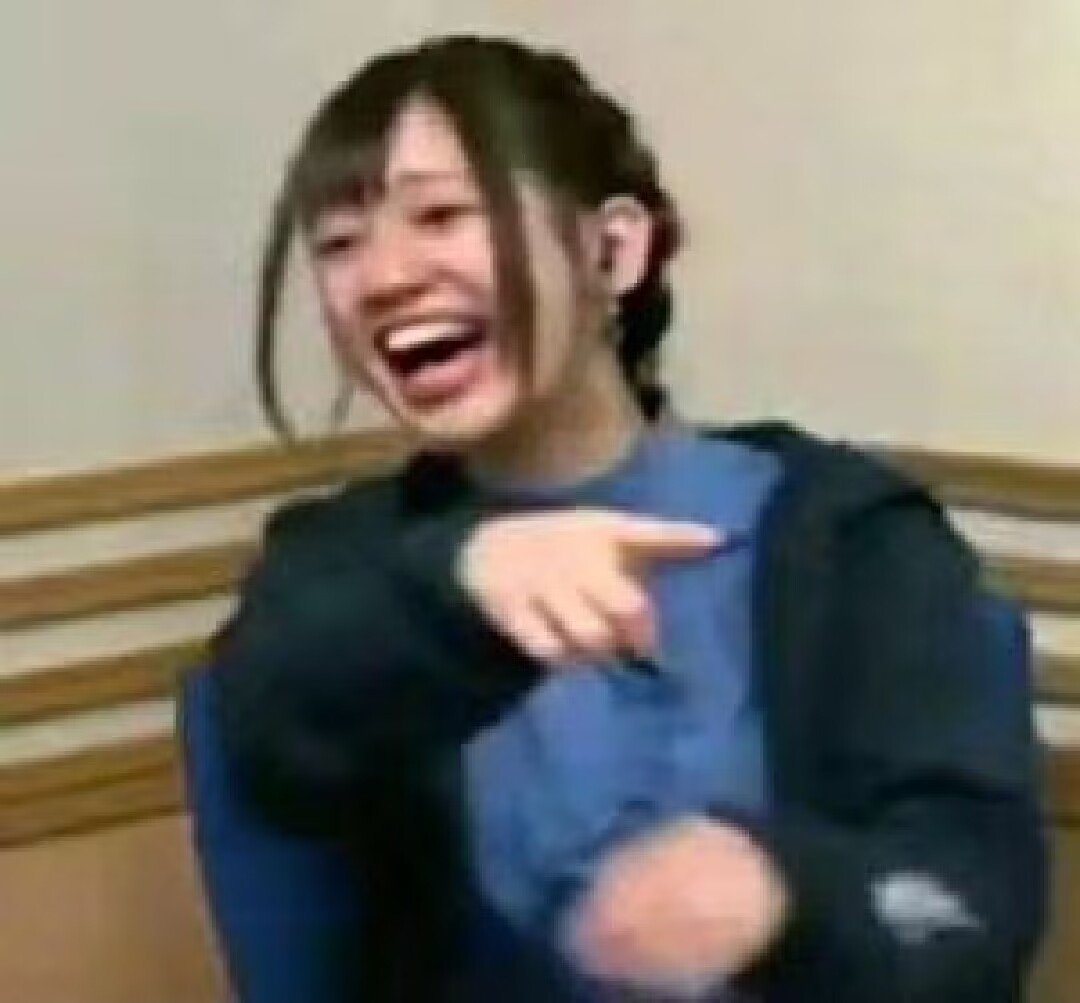

# <center>《Deep Residual Learning for Image Recognition》论文复现</center>

#### <center>范圣如 320220937791</center>

## 1.Introduction
本次选取的论文为深度学习领域的经典论文《Deep Residual Learning for Image Recognition》，即何凯明等行业大牛提出大名鼎鼎的ResNet（残差网络）的论文。
我没有选取较前沿的论文，而是选择了这篇已经发表了接近10年的经典之作，主要原因如下：<br><br>
*尽管在一年多前，我就已经在《动手学深度学习》这部书中学习过了残差网络，但还没有阅读过原论文。一篇论文之所以能够成为经典，一定有其过人之处，值得重新阅读;<br>
这篇论文的正确性已经得到过大量实证，不会出现无法复现、结论存疑的情况;<br>
由于我的硬件设备比较一般，选择熟悉的细分领域可以方便调参与控制训练规模，最大程度发挥设备的性能。<br><br>*
接下来，我将逐步分析这篇论文中的核心理论，并复现论文中的重要实验。<br>

## 2.重要项说明

**Github项目地址(已将本次作业上传Github方便在线查阅)：**[Reproduction-of-ResNet](https://github.com/NOIPplayer/Reproduction-of-ResNet)<br>
**在线论文地址(本地pdf也已打包上传)：**[Deep Residual Learning for Image Recognition (thecvf.com) ](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)<br>
**参考书目：**[动手学深度学习](https://zh-v2.d2l.ai/d2l-zh-pytorch.pdf)<br>
**复现目标：**解释清楚论文的核心理论；用代码实现残差块，构建18层、34层、50层、101层残差网络；在本地使用Fashion Mnist数据集训练18层、34层、50层残差网络，画出图像，并与论文中的图像进行对比。部分参数根据实际情况做出了一定调整，下文将详细说明。<br>
**GPU：**RTX 3060<br>
**环境：**Python 3、Anaconda3<br>
**框架：**Pytorch<br>
**依赖包：**torch ver = 2.0.1, d2l ver = 0.17.6, numpy ver =  1.26.1, pandas ver = 1.2.4, torchvision ver = 0.15.2, matplotlib ver = 3.5.1, jupyter ver = 1.0.0<br>
**时间：**2024年12月<br>

## 3.论文解读

### 3.1残差网络解决的主要问题与核心思想

在本论文发表之前，深度学习中广泛存在神经网络在层数较深时，继续加深层数会导致训练效果大幅度倒退的问题。这个问题的主要原因是计算机的数据精度是有限的，在数据传递到深层神经网络时，可能因为已经经过大量的计算导致精度丢失，最后变成了零，这个时候梯度消失，神经网络失效。该问题严重困扰着当时的学界。<br>
文章在开头用两幅图说明了这一问题，可以看到，不论是训练正确率还是测试正确率，20层的传统神经网络都比56层的传统神经网络更高，这是十分反直觉的。<br>
<img src=".\img\1.png" width="70%" title = "Figure 1">
<center>Figure 1 传统神经网络训练过程中出现的问题</center><br>
而何凯明等人提出了残差网络，要解决的核心问题就是深层神经网络训练过程中的梯度消失问题。<br>
残差网络的核心思想是：每个附加层都应该更容易地包含原始函数作为其元素之一，这样，就算数据在经过一层神经网络后变得很小，也还会包含原始函数传来的数据，总体来说就不容易变得十分接近零，也就不容易出现梯度消失的现象。<br>

### 3.2残差网络的理论分析与代码实现
#### 3.2.1理论分析

残差网络的关键创新点在于引入了shortcut connections，即跳过一层或多层的连接。这些连接使得信息能够更加顺畅地传递，避免梯度在传播过程中消失。通过这种方式，ResNet可以训练非常深的网络，而不会出现性能下降的问题。我们用两张图来说明残差块和以往的不同之处。<br>
<img src=".\img\2.png" width="50%" title = "Figure 2">
<center>Figure 2 论文原图：残差块</center><br>
<img src=".\img\3.png" width="50%" title = "Figure 3">
<center>Figure 3 普通块（左）与残差块（右）</center><br>

论文中给出了18层、34层、50层、101层、152层残差网络的架构，网络间的主要区别在于残差块的数量和是否在输入输出时使用1\*1卷积层调整通道和分辨率。所有细节都可以从下图中看出。<br>
<img src=".\img\4.png" width="100%" title = "Figure 4">
<center>Figure 4 不同深度残差网络的架构</center><br>

在接下来的复现中，我将用代码实现这五种残差网络，并真正训练18层、34层和50层的残差网络，做出图像。<br>

#### 3.2.2残差块的代码实现
按照论文中的描述与3.2.1中的图像，给出残差块的代码实现如下：<br>
```
class Residual(nn.Module):
    def __init__(self,in_channes,out_channes,use_1x1_conv=False,stride = 1):
        super().__init__()
        if use_1x1_conv:
            self.res = nn.Sequential(
                nn.Conv2d(in_channes,out_channes,kernel_size=1,stride=stride)
            )
        else:
            self.res = nn.Sequential()
        self.model =nn.Sequential(
            nn.Conv2d(in_channes,out_channes,kernel_size=3,padding=1,stride=stride),
            nn.BatchNorm2d(out_channes),
            nn.ReLU(),
            nn.Conv2d(out_channes,out_channes,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channes)
        )
 
    def forward(self,x):
        ret = self.model(x)
        ret = ret+self.res(x)
        return F.relu(ret)
```

#### 3.2.3残差网络的代码实现
ResNet_18的代码实现如下：<br>
```
in_channels = 1
b1 = nn.Sequential(
    nn.Conv2d(in_channels,64,kernel_size=7,stride=2,padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)
b2 = nn.Sequential(*resnet_block(2,64,64, first_block=True))
b3 = nn.Sequential(*resnet_block(2,64,128))
b4 = nn.Sequential(*resnet_block(2,128,256))
b5 = nn.Sequential(*resnet_block(2,256,512))

resnet = nn.Sequential(b1,b2,b3,b4,b5,
                  nn.AdaptiveAvgPool2d((1,1)),
                  nn.Flatten(),nn.Linear(512,10)
                  )
```
ResNet_34的代码与ResNet_18相似，只需要修改b2 - b5（即第2-5个块）的参数即可。<br>
```
b2 = nn.Sequential(*resnet_block(3,64,64, first_block=True))
b3 = nn.Sequential(*resnet_block(4,64,128))
b4 = nn.Sequential(*resnet_block(6,128,256))
b5 = nn.Sequential(*resnet_block(3,256,512))
```
ResNet_50的代码与前两个网络的最大区别在于输入输出时使用了1\*1卷积层调整通道和分辨率，其他参数是一样的。<br>
```
b2 = nn.Sequential(*resnet_block(3,64,64))
b3 = nn.Sequential(*resnet_block(4,64,128,True))
b4 = nn.Sequential(*resnet_block(6,128,256,True))
b5 = nn.Sequential(*resnet_block(3,256,512,True))
```
ResNet_101的代码与ResNet_50相似，只需要修改b2 - b5（即第2-5个块）的参数即可。<br>
```
b2 = nn.Sequential(*resnet_block(3,64,64))
b3 = nn.Sequential(*resnet_block(4,64,128,True))
b4 = nn.Sequential(*resnet_block(23,128,256,True))
b5 = nn.Sequential(*resnet_block(3,256,512,True))
```
ResNet_152的代码与ResNet_50、ResNet_101相似，只需要修改b2 - b5（即第2-5个块）的参数即可。<br>
```
b2 = nn.Sequential(*resnet_block(3,64,64))
b3 = nn.Sequential(*resnet_block(4,64,128,True))
b4 = nn.Sequential(*resnet_block(23,128,256,True))
b5 = nn.Sequential(*resnet_block(3,256,512,True))
```
至此，论文的核心部分已经复现成功，残差网络已经搭建完毕，可以进行训练。

## 4.正式训练前的准备
### 4.1数据集选取与处理

原论文使用的数据集为Cifar-10，这是一个图像类型的数据集，已经与其他文件一起打包上传。但是，这个数据集的规模过于庞大，而且里面的图像为彩色图像，有3个输入维度，训练难度太大，对于我目前拥有的GPU算力是一个巨大的挑战。<br>
<img src=".\img\5.png" width="50%" title = "Figure 5">
<center>Figure 5 Cifar-10数据集</center><br>
因此，我选用了规模更小、仅有2个输入维度的Fashion Mnist数据集。Fashion Mnist数据集包含70000张灰度图像，其中包含60000个示例的训练集和10000个示例的测试集，每个示例都是一个28x28灰度图像。Fashion Mnist数据集与Cifar-10数据集均为图像类型数据集，相似度较高，且使用过的人数均数以万计，用前者代替后者具有合理性。在读取数据集时，我选用了小批量依次读取的方式以达到更好的训练效果。<br>

[Fashion Mnist源地址链接](https://www.worldlink.com.cn/en/osdir/fashion-mnist.html)<br>

### 4.2测试网络
在正式训练开始之前，一般都会先用小批量数据检测神经网络是否正常，层与层之间的数据输入输出形状是否正确。我用下面这段代码来测试网络的有效性，并观察ResNet中不同模块的输入与输出形状是如何变化的。理论上应该出现的输入与输出形状已经在3.2.1中的Figure 4给出。<br>
```
test = torch.rand((1,1,224,224))
print("test net")
for layer in resnet:
    test = layer(test)
    print(layer.__class__.__name__,"shape:",test.shape)//这行代码会输出每个layer中的数据形状（shape）
```
输出结果如下图所示：<br>
<img src=".\img\6.png" width="70%" title = "Figure 6">
<center>Figure 6 网络中数据形状的变化示例</center><br>
可以看到，神经网络表现出的实际情况与理论预期完全一致，这就证明了我们的代码架构是十分正确的。

## 5.正式训练与结果展示
### 5.1训练目标与思路
原论文中给出了ResNet的实验图像，如图所示。纵坐标为错误率error，横坐标为迭代数iter。在接下来的训练中，我也将以此为目标，尽可能地还原出相似的图像。原图中最深层次的网络为ResNet_110，而不是之前提到过的ResNet_101，这是因为作者想与另一种有110层的神经网络在同样的深度下做对比。<br>
<img src=".\img\7.png" width="40%" title = "Figure 7">
<center>Figure 7 原论文训练结果</center><br>
需要说明的是，原论文没有给出训练方法的具体细节，只能从图像中推断，作者的训练过程总体上比较常规与传统，只是在函数图像接近平滑的时候突然增大了一下学习率，在函数图像再次接近平滑的时候结束训练。至于什么时候调整学习率、什么时候结束、还有什么内部细节之类的东西，众所周知，这八成是多次尝试后得出的经验之谈，为了更好的结果甚至可能会做一些非常规的调整，就连大佬的论文也免不了这样。因此在接下来的训练中我不会中途调整学习率或者做别的调整，只按常规流程训练。<br>


### 5.2训练函数
原论文没有说明具体的训练方法与过程，也就是说训练方法在这篇论文中不重要，不是复现的要点。因此我就直接调用了d2l库中的train_ch6函数进行训练，这d2l库中是一个专门针对训练小规模ResNet的函数。其中，损失函数采用了交叉熵损失函数（CrossEntropyLoss），优化器采用了SGD，是很经典的训练方式，没有任何创新点，不做详细解释。<br>
需要注意的是，正式训练中的纵坐标用正确率代替错误率，横坐标用epoch代替iter（都是一样的意思，只是让图像更美观），并增加了训练损失loss。由于硬件条件所限，训练是逐个进行的，而且epoch不统一，故图像分开显示，没有像原论文一样合并成一张图。<br>
具体代码如下：
```
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    Defined in :numref:`sec_lenet`"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
```
### 5.3ResNet_18

训练ResNet_18时的**重要参数**如下：<br>
学习率lr = 0.05<br>
迭代轮数num_epochs = 10<br>
批量batch_size = 128<br><br>
训练结果如图所示：
<img src=".\img\resnet18_2.png" width="40%" title = "resnet18">
<img src=".\img\resnet18.png" width="40%" title = "resnet18">
<center>ResNet_18</center><br>

**可以看到，ResNet_18的训练是比较成功的，正确率达到了较高的水平，但在最后一轮训练中出现了轻微的过拟合问题。**<br><br>
注：过拟合是指训练误差和测试误差之间的差距太大。换句换说，就是模型复杂度高于实际问题，模型在训练集上表现很好，但在测试集上却表现很差。模型对训练集"死记硬背"，没有理解数据背后的规律，泛化能力差。在本次训练中表现为train_acc仍在上升，而test_acc却开始下降，但是幅度很轻微，不影响我们下结论。

### 5.4ResNet_34

训练ResNet_34时的**重要参数**如下：<br>
学习率lr = 0.05<br>
迭代轮数num_epochs = 10<br>
批量batch_size = 128<br><br>
训练结果如图所示：
<img src=".\img\resnet34.png" width="40%" title = "resnet34">
<center>ResNet_34</center><br>

**可以看到，ResNet_34在epoch只有ResNet_18一半的情况下，最终的正确率依然超过了ResNet_18，完全没有出现梯度消失、效果倒退等问题，与理论预期相符。**

### 5.5ResNet_50

当网络深度来到50层时，训练速度大幅下降，因此将num_epochs由原来的10缩减为5。
训练ResNet_50时的**重要参数**如下：<br>
学习率lr = 0.05<br>
迭代轮数num_epochs = 5<br>
批量batch_size = 128<br><br>
训练结果如图所示：
<img src=".\img\resnet50.png" width="40%" title = "resnet50">
<center>ResNet_50</center><br>

**可以看到，ResNet_50的最终的正确率与ResNet_34大致持平，没有出现梯度消失、效果大幅度倒退等问题，与理论预期相符。**

### 5.6ResNet_101

当网络深度来到101层时，一轮迭代需要的时间超过了6个小时，这意味着要想在合理的时间内完成训练，就必须大幅调整参数或者提升算力，但经实测，前者会导致训练结果较大偏离正常值，而后者需要大量金钱花费，因此只在附录给出理论上可行的代码，不进行正式训练。<br>

## 6.结论与反思
### 6.1结论
至此，论文复现已经全部完成。<br>
经过理论分析后，我在Part 3中成功用代码复现了残差块与残差网络，并在实际测试中得出了与理论预测相符的结果，证明了残差网络的存在性与可行性。<br>
经过实验分析后，从Part 5中的图像对比可以看出，ResNet没有因为神经网络的层数加深而出现梯度消失的现象，即便将深度翻倍，最后的正确率依然维持在一个变化很小的水平，不像其他传统神经网络一样出现正确率大幅下滑的现象。虽然复现结果不如原论文的结果漂亮，但也足够证明论文中提出的核心理论，即证明了ResNet可以解决传统神经网络加深层数会导致训练效果大幅倒退的问题。<br>
整体而言，本次论文复现达到了预期的目标，得出了和原论文中一样的过程和结论，证明了原论文核心部分是完全正确的，是一次成功的论文复现。<br>
### 6.2反思
在成功之余，本次复现也存在一定的不足之处，如没有完整训练101层与152层残差网络、训练轮数较少、训练ResNet_18时出现了轻微的过拟合问题等。如果想要得出更好的复现实验结果，应该通过在云平台上租赁算力等方式消除硬件短板，尽可能训练更深的ResNet并与其他神经网络比较。